In [132]:
import numpy as np
import os
import pandas as pd 
import cv2
import imutils
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [100]:
# classes = {"kirmizi_(red)":0,"sari_(yellow)":1,"yesil_(green)":2,"sol_kirmizi_(left_red)":3,"sag_kirmizi_(right_red)":4,"duz_kirmizi_(ahead_red)":5,"sol_sari_(left_yellow)":6,"sag_sari_(right_yellow)":7,"duz_sari_(ahead_yellow)":8,"sol_yesil_(left_green)":9,"sag_yesil_(right_green)":10,"duz_yesil_(ahead_green)":11}
classes = {"kirmizi_(red)":0,"sari_(yellow)":1,"yesil_(green)":2,"sol_kirmizi_(left_red)":3,"sag_kirmizi_(right_red)":4,"duz_kirmizi_(ahead_red)":5,"sol_sari_(left_yellow)":6,"sag_sari_(right_yellow)":7,"duz_sari_(ahead_yellow)":8,"sol_yesil_(left_green)":9,"sag_yesil_(right_green)":10,"duz_yesil_(ahead_green)":11,"kirmizi_sari_(red_yellow)":12,"duz_kirmizi_sari_(ahead_red_yellow)":13,"sol_kirmizi_sari_(left_red_yellow)":14,"sag_kirmizi_sari_(right_red_yellow)":15}

In [101]:
def readDf(path):
    df = pd.read_csv(path)
    df = df.drop(columns='width')
    df = df.drop(columns='height')
    df = df.drop(columns='xmin')
    df = df.drop(columns='xmax')
    df = df.drop(columns='ymin')
    df = df.drop(columns='ymax')  
    df = df.drop(columns='class')
    df["Sinif"] = [classes[item] for item in df['name']]
    df = df.drop(columns='name')
    return df

In [102]:
test_path = 'dataset_v2/test'
train_path = 'dataset_v2/train'
trainDf = readDf('dataset_v2/train.csv')
testDf = readDf('dataset_v2/test.csv')
trainDf

,file,Sinif
0,IMG_5350.jpg,0
1,IMG_5350.jpg,0
2,IMG_5350.jpg,0
3,IMG_8382.jpg,11
4,IMG_8382.jpg,10
...,...,...
695,light_033.jpg,15
696,light_033.jpg,15
697,IMG_5472.jpg,2
698,IMG_5472.jpg,2


/home/seventhson/miniconda3/envs/ml/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Işık sınıflarının dağılımı'}, xlabel='Sinif', ylabel='count'>

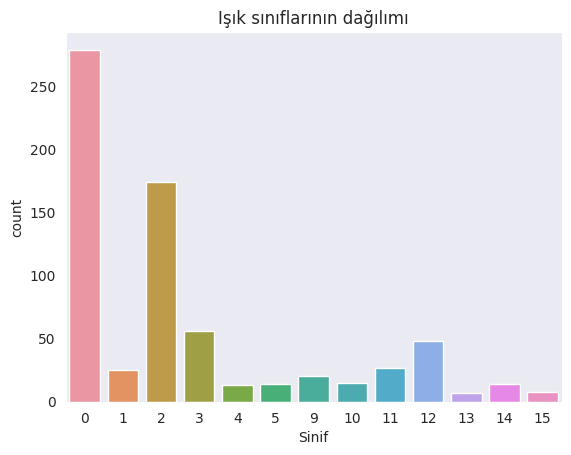

In [103]:
plt.title('Işık sınıflarının dağılımı')
sns.countplot(trainDf['Sinif'])

In [104]:
train_image_paths = []
train_imageId = dict()
for image in os.listdir(train_path):
    if (str(image)[-3:] == 'jpg'):
        train_imageId[str(image)] = len(train_image_paths)
        train_image_paths.append(image)
train_image_paths
print(len(train_image_paths))

321


In [105]:
test_image_paths = []
test_imageId = dict()
for image in os.listdir(test_path):
    if (str(image)[-3:] == 'jpg'):
        test_imageId[str(image)] = len(test_image_paths)
        test_image_paths.append(image)
test_image_paths
print(test_imageId)
print(len(test_image_paths))

{'light_014.jpg': 0, 'IMG_8401.jpg': 1, 'IMG_8630.jpg': 2, 'IMG_1026.jpg': 3, 'IMG_1067.jpg': 4, 'IMG_0745.jpg': 5, 'IMG_5354.jpg': 6, 'IMG_5286.jpg': 7, 'IMG_9013.jpg': 8, 'IMG_5570.jpg': 9, 'light_046.jpg': 10, 'IMG_8884.jpg': 11, 'IMG_1467.jpg': 12, 'IMG_5750.jpg': 13, 'IMG_9001.jpg': 14, 'light_057.jpg': 15, 'light_034.jpg': 16, 'IMG_0969.jpg': 17, 'IMG_8503.jpg': 18, 'IMG_8605.jpg': 19, 'IMG_8626.jpg': 20, 'IMG_8865.jpg': 21, 'IMG_8388.jpg': 22, 'IMG_8397.jpg': 23, 'IMG_8470.jpg': 24, 'IMG_5493.jpg': 25, 'IMG_5267.jpg': 26, 'IMG_8960.jpg': 27, 'IMG_8460.jpg': 28, 'IMG_8635.jpg': 29, 'IMG_8589.jpg': 30, 'IMG_8440.jpg': 31, 'IMG_8666.jpg': 32, 'IMG_8567.jpg': 33, 'IMG_8947.jpg': 34, 'IMG_8363.jpg': 35, 'IMG_8395.jpg': 36, 'IMG_8956.jpg': 37, 'IMG_8528.jpg': 38, 'light_06.jpg': 39, 'IMG_9009.jpg': 40, 'IMG_5402.jpg': 41, 'IMG_8374.jpg': 42, 'IMG_8953.jpg': 43, 'IMG_8613.jpg': 44, 'IMG_0765.jpg': 45, 'IMG_8493.jpg': 46, 'IMG_0914.jpg': 47, 'IMG_8558.jpg': 48, 'IMG_8964.jpg': 49, 'ligh

In [106]:
trainLabels = [ [0]*len(train_image_paths) for _ in range(16) ]
trainData = trainDf.values.tolist()
cnt = 0
for row  in trainData:
    print(row[1])
    trainLabels[row[1]][train_imageId[row[0]]] = 1

0
0
0
11
10
14
14
12
12
9
9
2
2
3
3
0
0
2
2
11
10
9
11
9
10
2
0
10
3
0
3
3
0
0
0
2
2
2
2
1
1
1
1
0
0
0
3
3
10
0
2
0
0
0
0
0
0
5
4
0
3
12
12
0
3
3
0
0
0
0
0
0
0
0
0
0
0
5
4
4
9
10
0
0
2
2
2
2
2
12
0
0
0
0
2
2
4
3
5
0
0
0
0
0
0
5
2
2
2
0
0
0
12
14
12
12
2
2
2
12
0
2
2
0
0
0
0
0
0
12
0
0
2
0
12
15
15
0
13
15
0
0
0
2
2
2
2
0
0
0
0
2
1
1
1
5
2
3
2
2
2
2
3
2
2
3
5
5
4
3
0
0
0
2
2
2
2
0
2
12
0
0
0
2
2
3
0
2
2
3
0
0
0
0
0
9
11
2
2
2
2
2
2
2
14
14
12
12
0
0
0
0
0
0
0
0
0
0
0
0
2
1
2
0
0
0
0
0
2
2
0
12
12
12
3
12
12
2
2
2
5
3
11
11
12
13
12
2
0
3
3
0
0
2
2
2
0
0
0
0
0
0
2
2
2
9
11
9
2
2
11
3
2
2
2
2
0
0
0
0
0
0
2
2
2
0
14
11
11
11
2
15
9
11
0
4
4
3
0
1
2
2
3
0
2
2
0
0
0
0
0
2
2
2
12
0
0
0
0
3
5
5
4
12
12
0
0
1
0
0
0
2
2
12
12
15
0
4
0
2
2
14
14
12
12
2
2
2
3
11
11
2
0
2
1
0
0
2
0
0
2
2
2
3
3
3
0
0
13
15
9
10
0
0
0
0
0
0
0
0
0
3
3
9
2
2
0
0
2
10
0
0
0
0
0
3
3
11
11
10
0
12
12
0
2
0
0
9
9
2
2
2
0
0
11
10
2
9
10
3
0
11
11
0
0
2
2
12
2
2
2
2
0
0
0
9
10
2
2
0
0
0
3
0
0
0
0
1
1
10
2
2
2
0
2
3
0
0
2
0


In [107]:
testLabels = [ [0] * len(test_image_paths) for _ in range(16) ]
testData = testDf.values.tolist()
cnt = 0
for row  in testData:
    testLabels[row[1]][test_imageId[row[0]]] = 1

In [108]:
def image_to_feature_vector(image, size=(32, 32)):
	return cv2.resize(image, size).flatten()

In [109]:
def extract_color_histogram(image, bins=(8, 8, 8)):
	hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
	hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
	if imutils.is_cv2():
		hist = cv2.normalize(hist)
	else:
		cv2.normalize(hist, hist)
	return hist.flatten()

In [110]:
rawImages = []
features = []
for image_path in train_image_paths:
	image = cv2.imread(train_path + '/' + image_path)
	pixels = image_to_feature_vector(image)
	hist = extract_color_histogram(image)

	rawImages.append(pixels)
	features.append(hist)

In [111]:
test_rawImages = []
test_features = []
for image_path in test_image_paths:
	image = cv2.imread(test_path + '/' + image_path)
	pixels = image_to_feature_vector(image)
	hist = extract_color_histogram(image)

	test_rawImages.append(pixels)
	test_features.append(hist)

In [112]:
rawImages = np.array(rawImages)
features = np.array(features)
# labs = np.array(trainLabels[2])

In [116]:
model = [0]*16
for i in range(16):
    model[i] = KNeighborsClassifier(n_neighbors=2,n_jobs=-1)
    model[i].fit(features, trainLabels[i])

In [118]:
# print(testLabels[1])
cumPred = []
cumLabel = []
for _ in range(len(test_imageId)):
	cumPred.append([])
	cumLabel.append([])

for i in range(16):
	predictions = model[i].predict(test_features).tolist()
	acc = model[i].score(test_features, testLabels[i])
	if (acc != 1):
		f1 = f1_score(testLabels[i],predictions)
	else:
		f1 = 1
	for j in range(len(predictions)):
		cumPred[j].append(predictions[j])
		cumLabel[j].append(testLabels[i][j])

	print('Acc for class ' + str(i) + " : " + str(acc))


print("Accuracy score : " + str(accuracy_score(cumLabel,cumPred)))
print("Recall score : " + str(recall_score(cumLabel,cumPred,average='weighted')))
print("Precision score : " + str(precision_score(cumLabel,cumPred,average='weighted')))
print("F1 score : " + str(f1_score(cumLabel,cumPred,average='weighted')))


Acc for class 0 : 0.725
Acc for class 1 : 0.925
Acc for class 2 : 0.85
Acc for class 3 : 0.9125
Acc for class 4 : 0.9625
Acc for class 5 : 0.9625
Acc for class 6 : 0.9875
Acc for class 7 : 1.0
Acc for class 8 : 1.0
Acc for class 9 : 0.975
Acc for class 10 : 0.9375
Acc for class 11 : 0.95
Acc for class 12 : 0.8875
Acc for class 13 : 0.9875
Acc for class 14 : 0.9625
Acc for class 15 : 0.9875
Accuracy score : 0.325
Recall score : 0.37383177570093457
Precision score : 0.7644010195412065
F1 score : 0.4905803697859772


/home/seventhson/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seventhson/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seventhson/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [137]:
def get_key(val):
    for key, value in classes.items():
         if val == value:
             return key

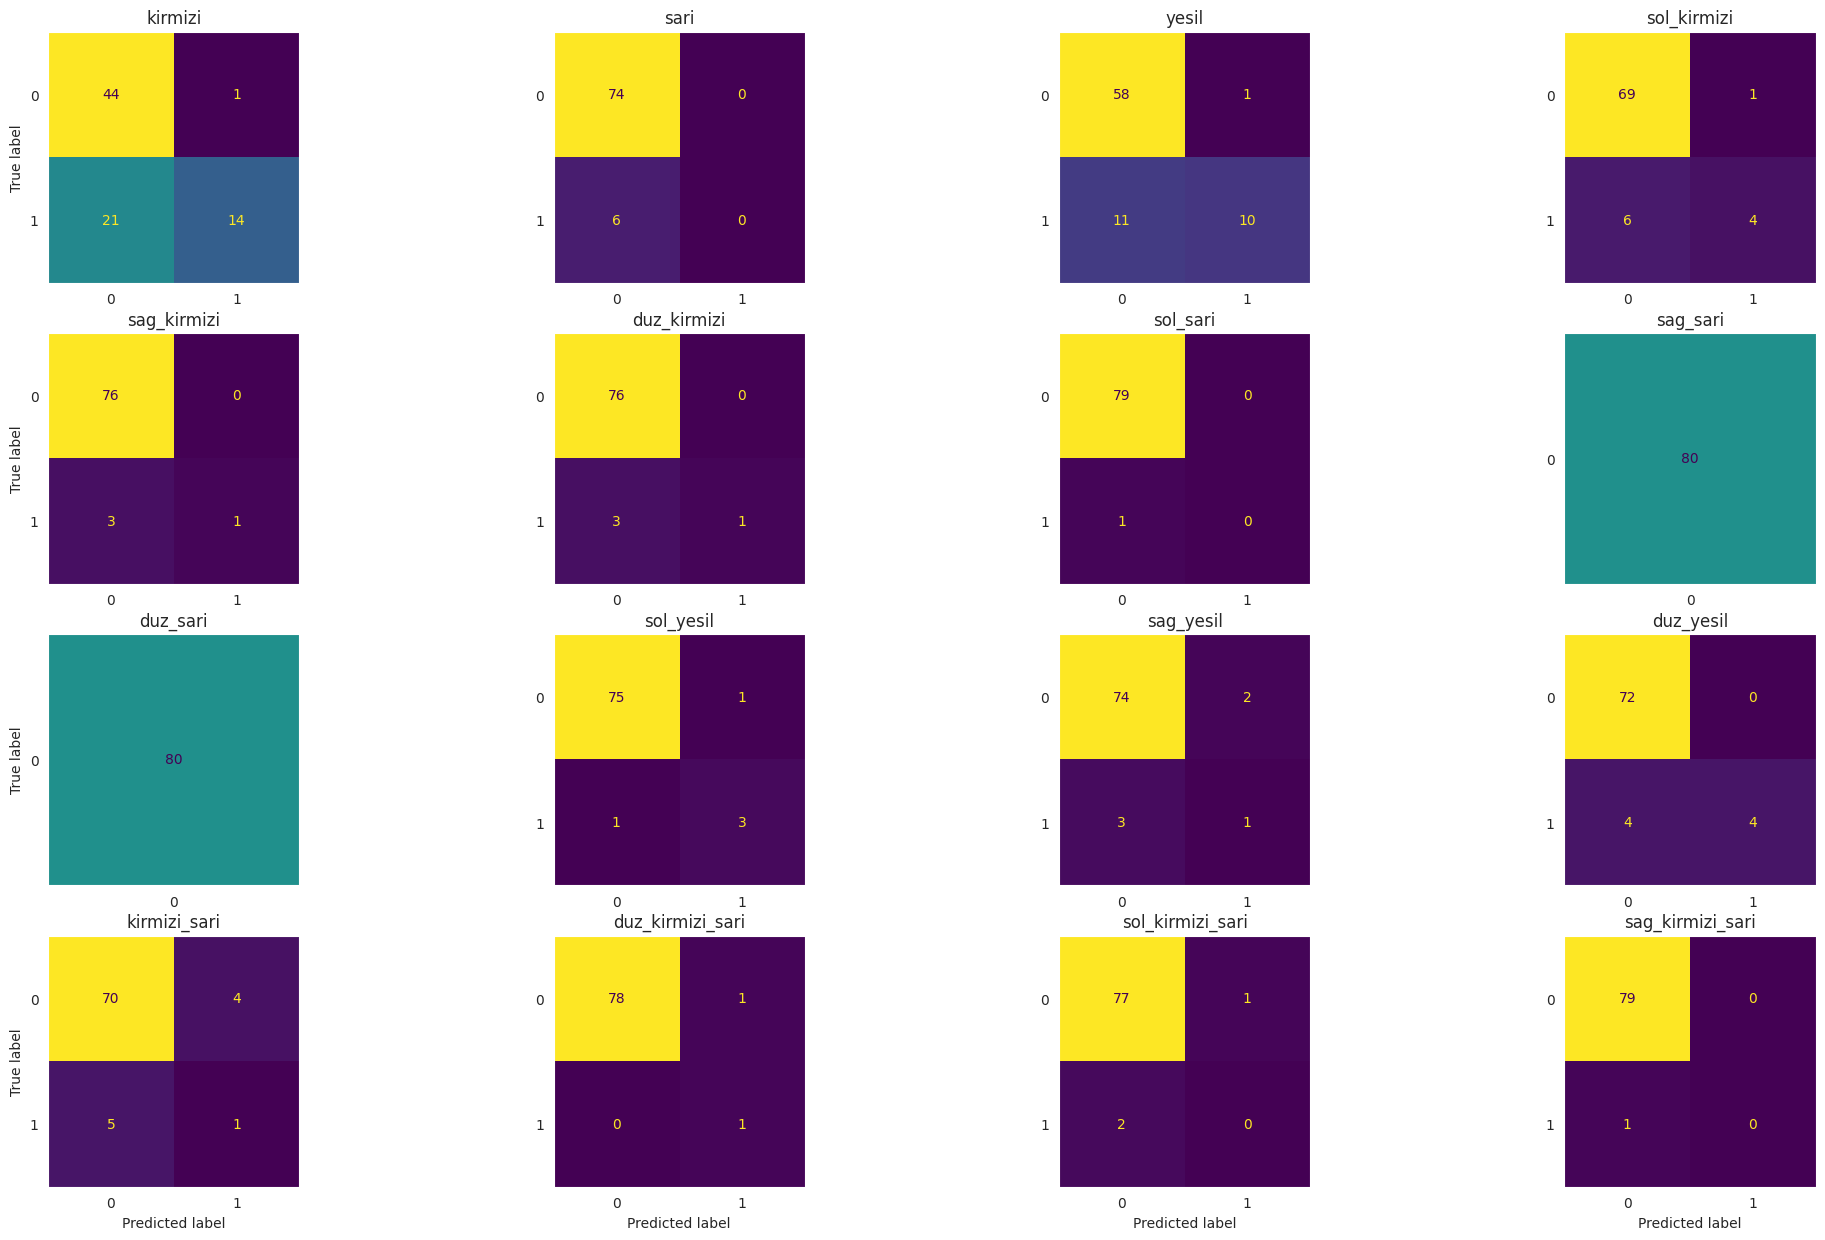

In [145]:
f, axes = plt.subplots(4, 4, figsize=(25, 15))
axes = axes.ravel()
for i in range(16):
    disp = ConfusionMatrixDisplay(confusion_matrix(testLabels[i],model[i].predict(test_features).tolist()))
    disp.plot(ax=axes[i], values_format='.4g')
    className = get_key(i).split('(')[0][:-1]
    disp.ax_.set_title(className)
    if i<12:
        disp.ax_.set_xlabel('')
    if i%4!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()